# Seismic modelling

This notebook is the first in a series of tutorials highlighting various aspects of seismic inversion based on Devito operators. In this first example we aim to highlight the core ideas behind seismic modelling, where we create a numerical model that captures the processes involved in a seismic survey. This forward model will then form the basis for further tutorials on the implementation of inversion processes using Devito operators.

## Modelling workflow

The core process we are aiming to model is a seismic survey, which consists of two main components:

- **Source** - A source is positioned at a single or a few physical locations where artificial pressure is injected into the domain we want to model. In the case of land survey, it is usually dynamite blowing up at a given location, or a vibroseis (a vibrating engine generating continuous sound waves). For a marine survey, the source is an air gun sending a bubble of compressed air into the water that will expand and generate a seismic wave.
- **Receiver** - A set of microphones or hydrophones are used to measure the resulting wave and create a set of measurements called a *Shot Record*. These measurements are recorded at multiple locations, and usually at the surface of the domain or at the bottom of the ocean in some marine cases.

In [5]:
import numpy as np
%matplotlib inline
from scipy.io import loadmat
import matplotlib.pyplot as plt
from functions import Model, plot_velocity, plot_stacking_chart, TimeAxis, RickerSource, Receiver
from devito import TimeFunction
from devito import Eq, solve
from devito import Operator
from scipy.io import savemat

# Acquisition geometry

To fully define our problem setup we also need to define the source that injects the wave to model and the set of receiver locations at which to sample the wavefield. In this case we use split spread, this is a method of reflection surveying in which the source point is at (or perpendicularly offset from) the center of the geophone spread.

<img src='./images/split-spread.png' width=400> 

In [6]:
#Upload data marmousi
mar_data = loadmat('data/marmousi_dz10.mat')    
x = mar_data['x'][0]  ## x is stored as an array inside an array
z = mar_data['z'][0]  ## z also. So we take just the first entry. 
vel = mar_data['vel']

nx = len(x)
nz = len(z)
print(nx,nz)

941 301


In [7]:
new_vel = np.zeros((351,941)) # New matriz of velocity
new_vel[:50,:] = 1500 # First layer
new_vel[50:,:] = vel

shape = (nx, nz+50)  # Number of grid point (nx, nz)
spacing = (10,10)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (x[0]/1000, z[0]) # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# velocity WALYS IN KM/S

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=new_vel.T/1000, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

Operator `initdamp` ran in 0.01 s


The source is positioned at a $20m$ depth and at the middle of line of receivers ($x_{src}=2000m$), with a peak wavelet frequency of $10Hz$.
In this example we will position receivers at the same depth as the source, every $20m$ along the x axis, for a total of $101$ receivers.

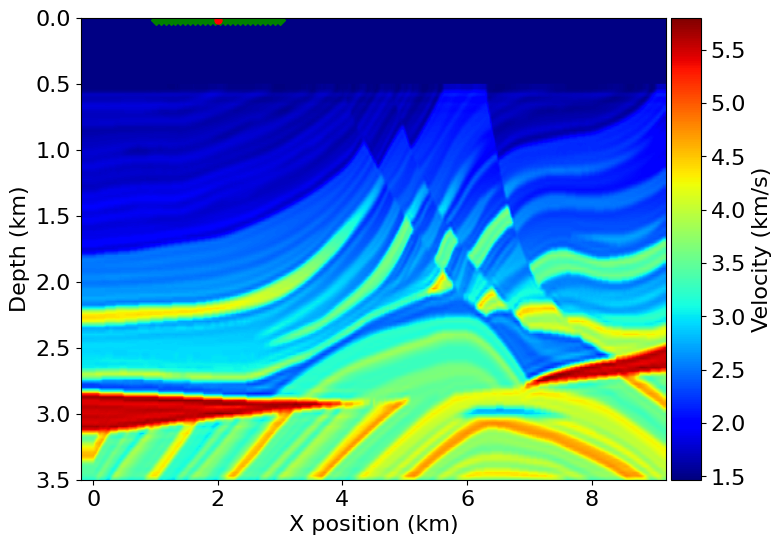

In [8]:
L = 2000 # Length line of receivers
x0 = 1000 # Initial position
sx = L/2 + x0

t0 = 0.  # Simulation starts a t=0
tn = 3000.  # Simulation last 1 second (3000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

#Source
f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, :] = sx
src.coordinates.data[0, -1] = 20.  # Depth is 20m

#Receiver
rx1 = sx-(L/2) 
rx2 = sx+(L/2)

num_receivers = 101

rec = Receiver(name='rec', grid=model.grid, npoint=num_receivers, time_range=time_range)          
rec.coordinates.data[:, 0] = np.linspace(rx1,rx2,num=num_receivers)    
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

In [9]:
print(dt)

1.056


In [10]:
recep_data = np.linspace(rx1,rx2,num=num_receivers)
print(np.diff(recep_data), len(recep_data))      

[20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.] 101


In this example to capture each shot we move both the line of receivers and the source $40𝑚$.

In [11]:
def modelingfunction(L, model, sx): # Function to generate the shot gather    
    #Source
    f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
    src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
    src.coordinates.data[0, :] = sx
    src.coordinates.data[0, -1] = 20.  # Depth is 20m

    #Receiver
    rx1 = sx-(L/2) 
    rx2 = sx+(L/2)

    num_receivers = 101

    rec = Receiver(name='rec', grid=model.grid, npoint=num_receivers, time_range=time_range)          
    rec.coordinates.data[:, 0] = np.linspace(rx1,rx2,num=num_receivers)    
    rec.coordinates.data[:, 1] = 20.  # Depth is 20m
    
    # In order to represent the wavefield u and the square slowness we need symbolic objects 
    # corresponding to time-space-varying field (u, TimeFunction) and 
    # space-varying field (m, Function)

    # Define the wavefield with the size of the model and the time dimension
    u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

    # We can now write the PDE
    pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
    
    # This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
    # Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
    # a time marching updating equation known as a stencil using customized SymPy functions
    stencil = Eq(u.forward, solve(pde, u.forward))
    
    # Finally we define the source injection and receiver read function to generate the corresponding code
    src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

    # Create interpolation expression for receivers
    rec_term = rec.interpolate(expr=u.forward)    
    
    # The argument subs=model.spacing_map causes the operator to substitute values for our current grid spacing 
    # into the expressions before code generation. 
    # This reduces the number of floating point operations executed by the kernel.
    op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
    
    # Now we can execute the create operator for a number of timesteps. 
    # We specify the number of timesteps to compute with the keyword time and the timestep size with dt.
    op(time=time_range.num-1, dt=model.critical_dt)
    
    # After running our operator kernel, the data associated with the receiver symbol rec.data 
    # has now been populated due to the interpolation expression we inserted into the operator.
    
    return rec.data

In [12]:
long = 5000 # Define the meters to move the line of receivers and the source
dist_shot = 40 
num_shots = int(long/dist_shot +1) # Define the number of shots
print(num_shots)

126


Now we define de staking chart to the acquisition geometry, in this example we capture 10 shots.

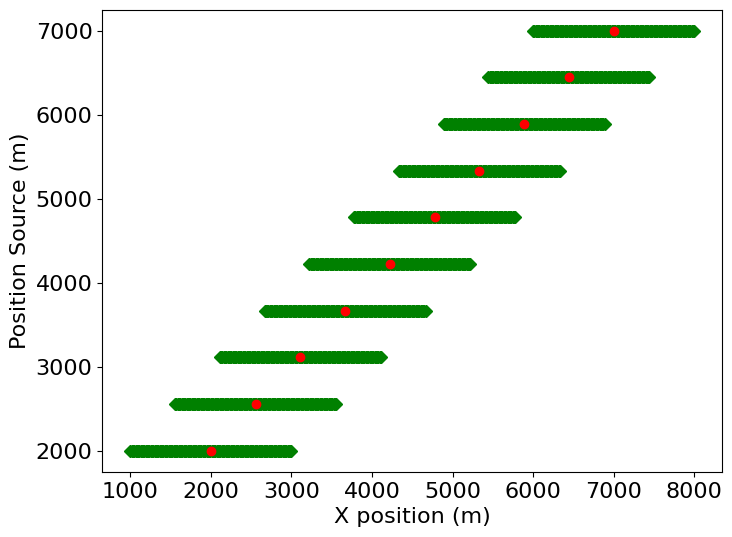

In [13]:
plot_stacking_chart(10, x0,L,long,'land') 

In [14]:
survey = np.zeros((2842, num_receivers, num_shots)) # Execute the funcition to acquired 81 shots

SX = np.linspace(x0+L//2,x0+L+long-L//2,num_shots)
SX

array([2000., 2040., 2080., 2120., 2160., 2200., 2240., 2280., 2320.,
       2360., 2400., 2440., 2480., 2520., 2560., 2600., 2640., 2680.,
       2720., 2760., 2800., 2840., 2880., 2920., 2960., 3000., 3040.,
       3080., 3120., 3160., 3200., 3240., 3280., 3320., 3360., 3400.,
       3440., 3480., 3520., 3560., 3600., 3640., 3680., 3720., 3760.,
       3800., 3840., 3880., 3920., 3960., 4000., 4040., 4080., 4120.,
       4160., 4200., 4240., 4280., 4320., 4360., 4400., 4440., 4480.,
       4520., 4560., 4600., 4640., 4680., 4720., 4760., 4800., 4840.,
       4880., 4920., 4960., 5000., 5040., 5080., 5120., 5160., 5200.,
       5240., 5280., 5320., 5360., 5400., 5440., 5480., 5520., 5560.,
       5600., 5640., 5680., 5720., 5760., 5800., 5840., 5880., 5920.,
       5960., 6000., 6040., 6080., 6120., 6160., 6200., 6240., 6280.,
       6320., 6360., 6400., 6440., 6480., 6520., 6560., 6600., 6640.,
       6680., 6720., 6760., 6800., 6840., 6880., 6920., 6960., 7000.])

In [15]:
survey = np.zeros((2842, num_receivers, num_shots)) # Execute the funcition to acquired 81 shots

SX = np.linspace(x0+L//2,x0+L+long-L//2,num_shots)

for i, sx in enumerate(SX):
    survey[:,:,i] = modelingfunction(L, model, sx)
    print(sx)

Operator `Kernel` ran in 1.07 s


2000.0


Operator `Kernel` ran in 1.24 s


2040.0


Operator `Kernel` ran in 1.07 s


2080.0


Operator `Kernel` ran in 1.24 s


2120.0


Operator `Kernel` ran in 1.04 s


2160.0


Operator `Kernel` ran in 1.11 s


2200.0


Operator `Kernel` ran in 1.14 s


2240.0


Operator `Kernel` ran in 1.11 s


2280.0


Operator `Kernel` ran in 1.15 s


2320.0


Operator `Kernel` ran in 1.03 s


2360.0


Operator `Kernel` ran in 1.08 s


2400.0


Operator `Kernel` ran in 1.08 s


2440.0


Operator `Kernel` ran in 1.07 s


2480.0


Operator `Kernel` ran in 1.06 s


2520.0


Operator `Kernel` ran in 1.08 s


2560.0


Operator `Kernel` ran in 1.05 s


2600.0


Operator `Kernel` ran in 1.10 s


2640.0


Operator `Kernel` ran in 1.07 s


2680.0


Operator `Kernel` ran in 1.03 s


2720.0


Operator `Kernel` ran in 1.10 s


2760.0


Operator `Kernel` ran in 1.07 s


2800.0


Operator `Kernel` ran in 1.21 s


2840.0


Operator `Kernel` ran in 1.20 s


2880.0


Operator `Kernel` ran in 1.07 s


2920.0


Operator `Kernel` ran in 1.02 s


2960.0


Operator `Kernel` ran in 1.11 s


3000.0


Operator `Kernel` ran in 1.27 s


3040.0


Operator `Kernel` ran in 1.07 s


3080.0


Operator `Kernel` ran in 1.05 s


3120.0


Operator `Kernel` ran in 1.04 s


3160.0


Operator `Kernel` ran in 1.07 s


3200.0


Operator `Kernel` ran in 1.12 s


3240.0


Operator `Kernel` ran in 1.13 s


3280.0


Operator `Kernel` ran in 1.12 s


3320.0


Operator `Kernel` ran in 1.09 s


3360.0


Operator `Kernel` ran in 1.05 s


3400.0


Operator `Kernel` ran in 1.03 s


3440.0


Operator `Kernel` ran in 1.01 s


3480.0


Operator `Kernel` ran in 1.03 s


3520.0


Operator `Kernel` ran in 1.04 s


3560.0


Operator `Kernel` ran in 1.07 s


3600.0


Operator `Kernel` ran in 1.11 s


3640.0


Operator `Kernel` ran in 1.22 s


3680.0


Operator `Kernel` ran in 1.05 s


3720.0


Operator `Kernel` ran in 1.04 s


3760.0


Operator `Kernel` ran in 1.07 s


3800.0


Operator `Kernel` ran in 1.04 s


3840.0


Operator `Kernel` ran in 1.13 s


3880.0


Operator `Kernel` ran in 1.13 s


3920.0


Operator `Kernel` ran in 1.16 s


3960.0


Operator `Kernel` ran in 1.01 s


4000.0


Operator `Kernel` ran in 1.09 s


4040.0


Operator `Kernel` ran in 1.03 s


4080.0


Operator `Kernel` ran in 1.02 s


4120.0


Operator `Kernel` ran in 1.02 s


4160.0


Operator `Kernel` ran in 1.04 s


4200.0


Operator `Kernel` ran in 1.01 s


4240.0


Operator `Kernel` ran in 1.07 s


4280.0


Operator `Kernel` ran in 1.07 s


4320.0


Operator `Kernel` ran in 1.07 s


4360.0


Operator `Kernel` ran in 1.05 s


4400.0


Operator `Kernel` ran in 1.10 s


4440.0


Operator `Kernel` ran in 1.11 s


4480.0


Operator `Kernel` ran in 1.13 s


4520.0


Operator `Kernel` ran in 1.06 s


4560.0


Operator `Kernel` ran in 1.06 s


4600.0


Operator `Kernel` ran in 1.07 s


4640.0


Operator `Kernel` ran in 1.05 s


4680.0


Operator `Kernel` ran in 1.06 s


4720.0


Operator `Kernel` ran in 1.07 s


4760.0


Operator `Kernel` ran in 1.09 s


4800.0


Operator `Kernel` ran in 1.04 s


4840.0


Operator `Kernel` ran in 1.06 s


4880.0


Operator `Kernel` ran in 1.03 s


4920.0


Operator `Kernel` ran in 1.06 s


4960.0


Operator `Kernel` ran in 1.05 s


5000.0


Operator `Kernel` ran in 1.05 s


5040.0


Operator `Kernel` ran in 1.04 s


5080.0


Operator `Kernel` ran in 1.02 s


5120.0


Operator `Kernel` ran in 1.06 s


5160.0


Operator `Kernel` ran in 1.02 s


5200.0


Operator `Kernel` ran in 1.06 s


5240.0


Operator `Kernel` ran in 1.03 s


5280.0


Operator `Kernel` ran in 1.03 s


5320.0


Operator `Kernel` ran in 1.06 s


5360.0


Operator `Kernel` ran in 1.07 s


5400.0


Operator `Kernel` ran in 1.02 s


5440.0


Operator `Kernel` ran in 1.04 s


5480.0


Operator `Kernel` ran in 1.03 s


5520.0


Operator `Kernel` ran in 1.04 s


5560.0


Operator `Kernel` ran in 1.03 s


5600.0


Operator `Kernel` ran in 1.03 s


5640.0


Operator `Kernel` ran in 1.03 s


5680.0


Operator `Kernel` ran in 1.06 s


5720.0


Operator `Kernel` ran in 1.05 s


5760.0


Operator `Kernel` ran in 1.02 s


5800.0


Operator `Kernel` ran in 1.03 s


5840.0


Operator `Kernel` ran in 1.02 s


5880.0


Operator `Kernel` ran in 1.02 s


5920.0


Operator `Kernel` ran in 1.04 s


5960.0


Operator `Kernel` ran in 1.03 s


6000.0


Operator `Kernel` ran in 1.08 s


6040.0


Operator `Kernel` ran in 1.04 s


6080.0


Operator `Kernel` ran in 1.05 s


6120.0


Operator `Kernel` ran in 1.02 s


6160.0


Operator `Kernel` ran in 1.02 s


6200.0


Operator `Kernel` ran in 1.03 s


6240.0


Operator `Kernel` ran in 1.03 s


6280.0


Operator `Kernel` ran in 1.02 s


6320.0


Operator `Kernel` ran in 1.01 s


6360.0


Operator `Kernel` ran in 1.01 s


6400.0


Operator `Kernel` ran in 1.08 s


6440.0


Operator `Kernel` ran in 1.04 s


6480.0


Operator `Kernel` ran in 1.04 s


6520.0


Operator `Kernel` ran in 1.05 s


6560.0


Operator `Kernel` ran in 1.05 s


6600.0


Operator `Kernel` ran in 1.03 s


6640.0


Operator `Kernel` ran in 1.05 s


6680.0


Operator `Kernel` ran in 1.03 s


6720.0


Operator `Kernel` ran in 1.04 s


6760.0


Operator `Kernel` ran in 1.05 s


6800.0


Operator `Kernel` ran in 1.05 s


6840.0


Operator `Kernel` ran in 1.03 s


6880.0


Operator `Kernel` ran in 1.04 s


6920.0


Operator `Kernel` ran in 1.03 s


6960.0


Operator `Kernel` ran in 1.03 s


7000.0


In [69]:
print(survey.shape)

(2842, 101, 126)


# Mask

We aplied a mask to eliminat the first event or direct wave.

Text(0, 0.5, 'time (s)')

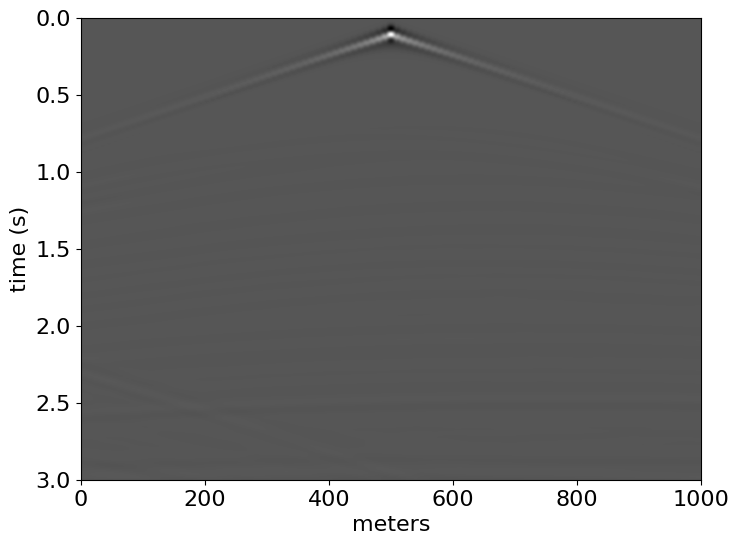

In [70]:
plt.imshow(survey[:,:,0],cmap='gray',aspect='auto', extent=(0,1000,3,0))
plt.xlabel('meters')
plt.ylabel('time (s)')

We need to calculate the straight line slope, once calculated we can generate a mask from this and we multiply each shot with the mask.

Text(0, 0.5, 'time (s)')

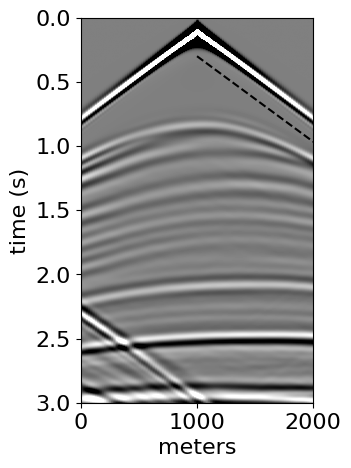

In [71]:
v = 1500 # Velocity
m = 1/v # Calculate the slope
x = np.linspace(1000,2000,100) # Define the values x 
t = m*(x-1000) # Define the values t 

plt.figure(figsize=(3,5))
plt.imshow(survey[:,:,0],cmap='gray',aspect='auto', extent=(0,2000,3,0),vmin=-0.5,vmax=0.5)
plt.plot(x,t+0.3,'--k')
plt.xlabel('meters')
plt.ylabel('time (s)')

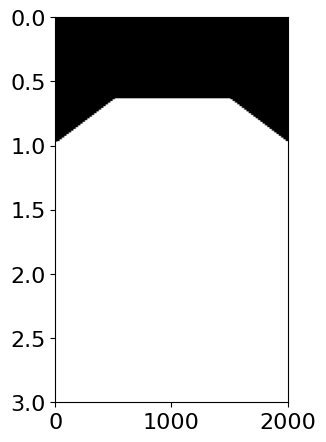

(2842, 101)


In [72]:
X,T = np.meshgrid(np.linspace(1000,2000,101//2), 
            np.linspace(0,3,2842)) # Generate the grid to calculate the mask


mask = T > m*(X-1000)+0.3 # Choose the values that satisfy the condition
mask1 = np.concatenate([np.flip(mask,axis=1),mask],axis=1) # Reflect the mask and concatenate
mask2 = np.ones((2842,1))
mask2[:920,:]=0
mask3 = np.concatenate([mask2,mask1],axis=1)

mask3[:600,:]=0 # Complete with zeros

plt.figure(figsize=(3,5))
plt.imshow(mask3,cmap='gray',aspect='auto',extent=(0,2000,3,0),vmin=0,vmax=1)
plt.show()
print(mask3.shape)

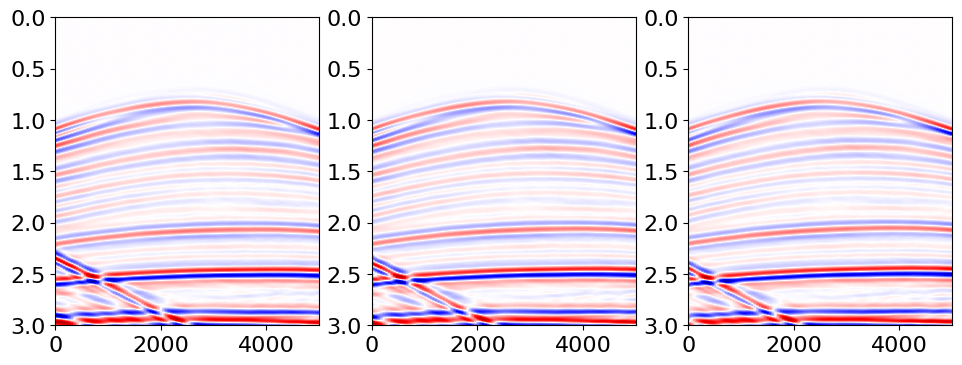

(2842, 101, 126)


In [73]:
TotalMask = mask3.copy()
data = np.zeros((survey.shape[0],survey.shape[1],survey.shape[2]))

for i in range(survey.shape[2]):
  data[:,:,i] = TotalMask*survey[:,:,i]

fig=plt.figure(figsize=(32, 4))
for i in range(1,4):
    img = data[:,:,int(i)]
    fig.add_subplot(1,8,i)
    plt.imshow(img,cmap='seismic',aspect='auto',extent=(0,5000,3,0))
    plt.clim([-1,1])
plt.show()
print(data.shape)

In [74]:
print(np.min(data),np.max(data))

-1.1544685363769531 0.8802880644798279


# Save data

We are going to export the data in two formats, NPY the standard binary file format in NumPy, and Mat format the binary data container format used by MATLAB.

In [75]:
with open('data/seismic_land_126shots.npy', 'wb') as q:
    np.save(q, data)

In [23]:
data_mat = {"data": data, "label": "data"}
savemat("data/seismic_land_126shots.mat", data_mat)